# S-Mobile: Predicting Customer Churn

In [1]:
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
rsm.__version__


'0.9.20'

In [2]:
## setup pyrsm for autoreload when you edit code and save
## nothing else needed!
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

In [3]:
# loading data
s_mobile = pd.read_parquet("data/s_mobile.parquet")
s_mobile.shape

(69000, 25)

In [4]:
rsm.md("data/s_mobile_description.md")

## S-mobile

Dataset used to investigate opportunities to decrease customer churn at S-mobile. The sample consists of three parts:

1. A training sample with 27,300 observations and a 50% churn rate ("training == 1")
2. A test sample with 11,700 observations and a 50% churn rate ("training == 0")
3. A representative sample with 30,000 observations and a churn rate of 2%, i.e., the actual monthly churn rate for S-mobile ("is.na(training)" or "representative == 1")

## Variables

* customer: Customer ID
* churn: Did consumer churn in the last 30 days? (yes or no)
* changer: % change in revenue over the most recent 4 month period
* changem: % change in minutes of use over the most recent 4 month period
* revenue: Mean monthly revenue in SGD
* mou: Mean monthly minutes of use
* overage: Mean monthly overage minutes
* roam: Mean number of roaming calls
* conference: Mean number of conference calls
* months: # of months the customer has had service with S-Mobile
* uniqsubs: Number of individuals listed on the customer account
* custcare: Mean number of calls to customer care 
* retcalls: Number of calls by the customer to the retention team
* dropvce: Mean number of dropped voice calls 
* eqpdays: Number of days customer has owned current handset
* refurb: Handset is refurbished (no or yes)
* smartphone: Handset is a smartphone (no or yes)
* creditr: High credit rating as opposed to medium or low (no or yes)
* mcycle: Subscriber owns a motorcycle (no or yes)
* car: Subscriber owns a car (no or yes)
* travel: Subscriber has traveled internationally (no or yes)
* region: Regions delineated by the 5 Community Development Council Districts (e.g., CS is Central Singapore)
* occupation: Categorical variable with 4 occupation levels (professional, student, retired, or other)
* training: 1 for training sample, 0 for test sample, NA for representative sample
* representative: 1 for representative sample, 0 for training and test sample


In [6]:
s_mobile.churn.value_counts(dropna=False)

churn
no     48900
yes    20100
Name: count, dtype: int64

In [7]:
# numeric version of churn for descriptive statistics
s_mobile["churn_yes"] = rsm.ifelse(s_mobile.churn == "yes", 1, 0)

In [8]:
s_mobile.loc[s_mobile.representative == 1, "churn_yes"].agg(["mean", "count"])

mean         0.02
count    30000.00
Name: churn_yes, dtype: float64

Generate `cweight` variable to scale predictions. The proportion of churn vs non-churn is 1 vs 49 (i.e., for every churner in the data, there are 49 non-churners)

In [9]:
s_mobile["cweight"] = rsm.ifelse(s_mobile.churn_yes == 1, 1, 49)

Check the proportion of churners in the different (sub) datasets

In [11]:
pd.get_dummies(
    s_mobile.loc[s_mobile.representative == 1, "churn"],
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
yes,0.02,0.140002,False,True
no,0.98,0.140002,False,True


In [12]:
pd.get_dummies(
    s_mobile.loc[s_mobile.representative == 0, "churn"],
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
yes,0.5,0.500006,False,True
no,0.5,0.500006,False,True


In [13]:
evar = s_mobile.loc[:, "changer":"occupation"].columns.to_list()
evar

['changer',
 'changem',
 'revenue',
 'mou',
 'overage',
 'roam',
 'conference',
 'months',
 'uniqsubs',
 'custcare',
 'retcalls',
 'dropvce',
 'eqpdays',
 'refurb',
 'smartphone',
 'highcreditr',
 'mcycle',
 'car',
 'travel',
 'region',
 'occupation']

In [14]:
lr = rsm.model.logistic(
    data={"s_mobile": s_mobile[s_mobile.training == 1]},
    rvar="churn",
    lev="yes",
    evar=evar,
)
lr.summary(main=False, fit=True)


Pseudo R-squared (McFadden): 0.085
Pseudo R-squared (McFadden adjusted): 0.084
Area under the RO Curve (AUC): 0.689
Log-likelihood: -17311.321, AIC: 34676.643, BIC: 34898.438
Chi-squared: 3223.193, df(26), p.value < 0.001 
Nr obs: 27,300


Another check of average predicted probability of churn in the different sub-datasets

In [15]:
s_mobile["p_churn"] = lr.predict(s_mobile)["prediction"]
s_mobile.fillna({"training": -1}).groupby("training")[["churn_yes", "p_churn"]].mean()

,churn_yes,p_churn
training,,
-1.0,0.02,0.444004
0.0,0.50,0.499093
1.0,0.50,0.500000


Predictions in training and test are 50% - 50%. The predicted probabilities in the representative sample are obviously much too high when we do not use weights. The predictions will need to be rescaled, e.g., by using weights. 

In [16]:
lrw = rsm.model.logistic(
    data={"s_mobile": s_mobile[s_mobile.training == 1]},
    rvar="churn",
    lev="yes",
    evar=evar,
    weights="cweight",
)
lrw.summary(main=False, fit=True)


Pseudo R-squared (McFadden): 0.047
Pseudo R-squared (McFadden adjusted): 0.046
Area under the RO Curve (AUC): 0.688
Log-likelihood: -63795.467, AIC: 127644.935, BIC: 127953.64
Chi-squared: 6232.455, df(26), p.value < 0.001 
Nr obs: 682,500


In [17]:
s_mobile["p_churnw"] = lrw.predict(s_mobile)["prediction"]
s_mobile.fillna({"training": -1}).groupby("training")[["churn_yes", "p_churnw"]].mean()

,churn_yes,p_churnw
training,,
-1.0,0.02,0.019804
0.0,0.50,0.024775
1.0,0.50,0.024748


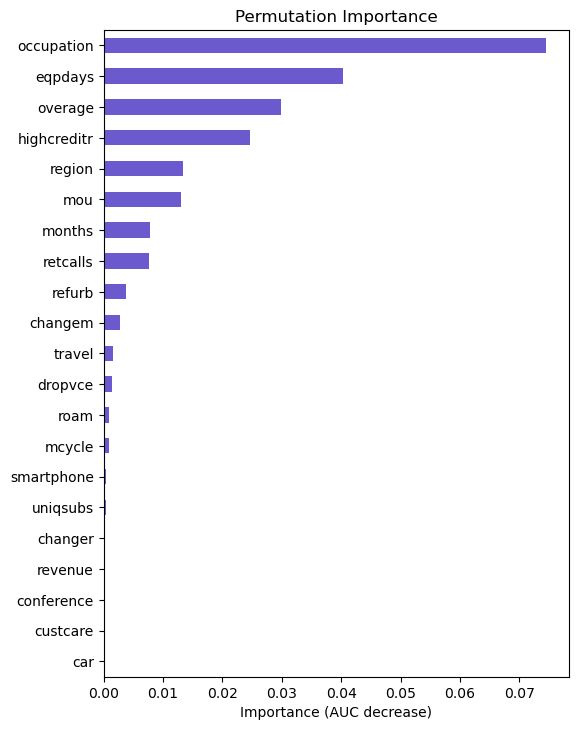

In [17]:
ret = rsm.vimp_plot_sm(lr_weights, s_mobile.query("training == 1"), ret=True)

In [18]:
# rsm.pred_plot_sm(lr, s_mobile[s_mobile.representative == 1], incl="dropvce", hline=False)
rep = s_mobile[s_mobile.training == 1]
rep.assign(dropvce = rep.dropvce > 0).groupby("dropvce").churn_yes.agg(np.mean)


dropvce
False    0.519066
True     0.491840
Name: churn_yes, dtype: float64

In [19]:
rep.assign(dropvce = rep.dropvce > 0).groupby("dropvce").p_churnw.agg(np.mean)
####
#THE BELOW SHOULD NOT BE HAPPENING
#
###

dropvce
False    0.025347
True     0.024491
Name: p_churnw, dtype: float64

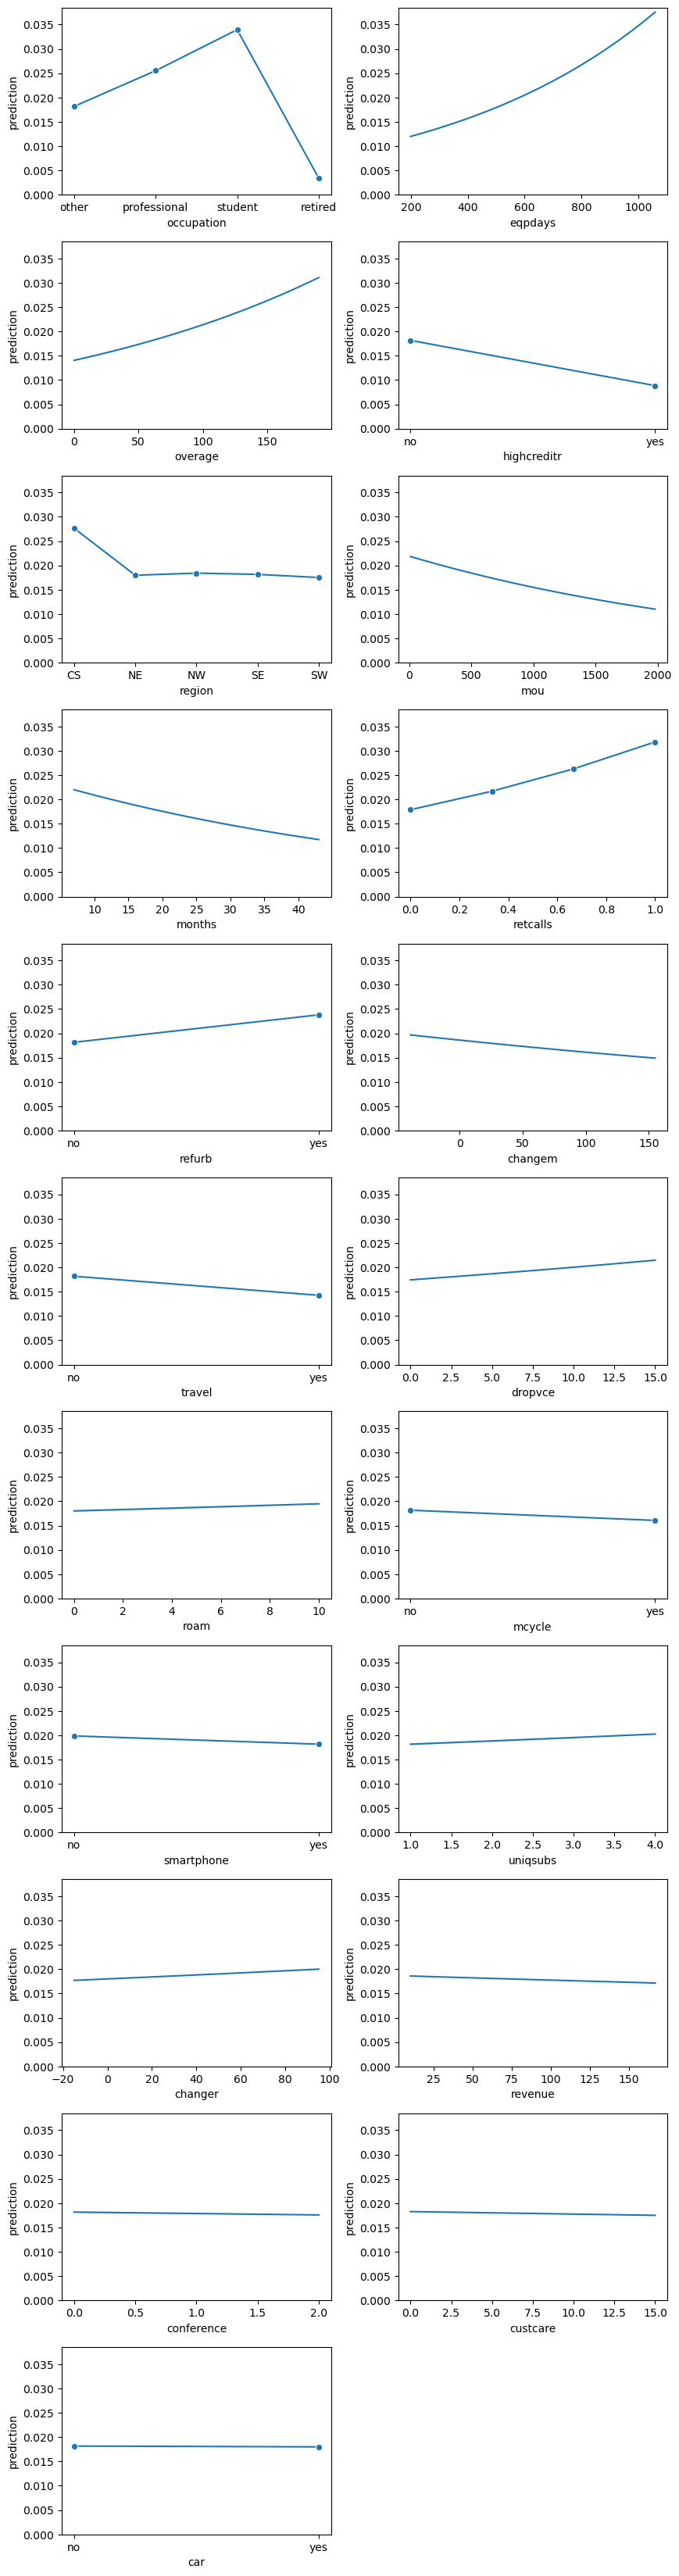

In [20]:
rsm.pred_plot_sm(lr_weights, s_mobile[s_mobile.representative == 1], incl=ret.index)


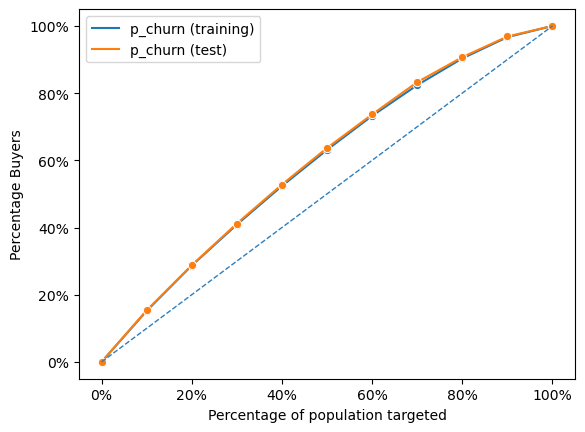

In [21]:
dct = {
    "training": s_mobile.query("training == 1"),
    "test": s_mobile.query("training == 0"),
}
fig = rsm.gains_plot(dct, "churn", "yes", "p_churn")


The AUC for test is (slightly) higher than in the training sample. The fit is not great so we should consider if an ML model might do better. 

In [22]:
rsm.evalbin(dct, "churn", "yes", "p_churn")[["Type", "predictor", "AUC"]]

,Type,predictor,AUC
0,training,p_churn,0.689
1,test,p_churn,0.695


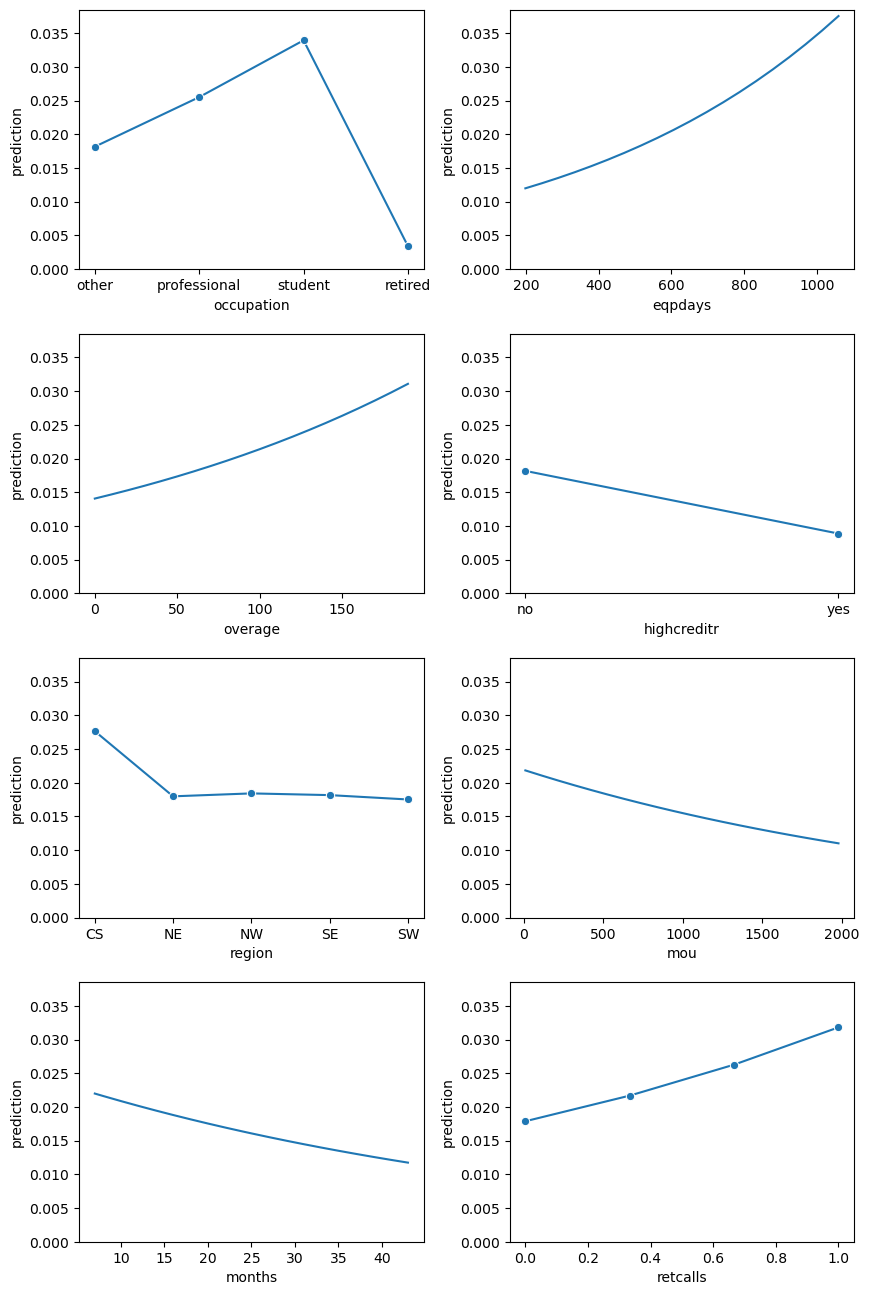

In [23]:
rsm.pred_plot_sm(
    lr_weights, s_mobile.query("representative == 1"), 
    incl=ret.index[:8]
)

`months_dec` is the month variable converted to dummy variables. This will turn out to be an important variable in the ML models estimated below.

In [24]:
# doing this over the entire dataset just like we used to do with RFM
s_mobile["months_dec"] = pd.Series(rsm.xtile(s_mobile.months, 10), dtype="category")

In [25]:
s_mobile["months_dec"] = pd.Series(rsm.xtile(s_mobile.months, 10), dtype="category")
s_mobile.query("training == 1").groupby("months_dec").months.agg(np.min)

months_dec
1      6
2      9
3     11
4     13
5     15
6     17
7     20
8     24
9     27
10    34
Name: months, dtype: int32

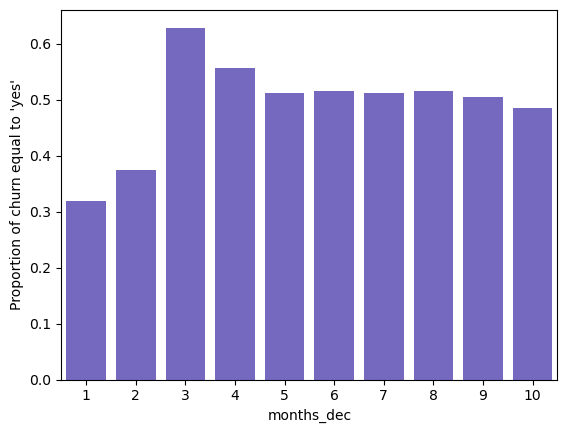

In [26]:
fig = rsm.prop_plot(s_mobile.query("training == 1"), "months_dec", "churn", "yes")

In [27]:
evar = list(s_mobile.loc[:, "changer":"occupation"].columns) + ["months_dec"]
form = "churn_yes ~ " + " + ".join(rsm.setdiff(evar, "months"))
form

'churn_yes ~ car + changem + changer + conference + custcare + dropvce + eqpdays + highcreditr + mcycle + months_dec + mou + occupation + overage + refurb + region + retcalls + revenue + roam + smartphone + travel + uniqsubs'

In [28]:
lr_mdec = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=s_mobile.query("training == 1"),
).fit()
rsm.or_ci(lr_mdec)

,index,OR,OR%,2.5%,97.5%,p.values,
1,car[T.yes],0.995,-0.5%,0.922,1.073,0.891,
2,highcreditr[T.yes],0.479,-52.1%,0.451,0.509,< .001,***
3,mcycle[T.yes],0.880,-12.0%,0.831,0.931,< .001,***
4,months_dec[T.2],1.120,12.0%,1.018,1.233,0.02,*
5,months_dec[T.3],3.110,211.0%,2.873,3.367,< .001,***
6,months_dec[T.4],2.188,118.8%,2.008,2.384,< .001,***
7,months_dec[T.5],1.727,72.7%,1.573,1.896,< .001,***
8,months_dec[T.6],1.596,59.6%,1.462,1.742,< .001,***
9,months_dec[T.7],1.465,46.5%,1.344,1.598,< .001,***
10,months_dec[T.8],1.332,33.2%,1.209,1.468,< .001,***


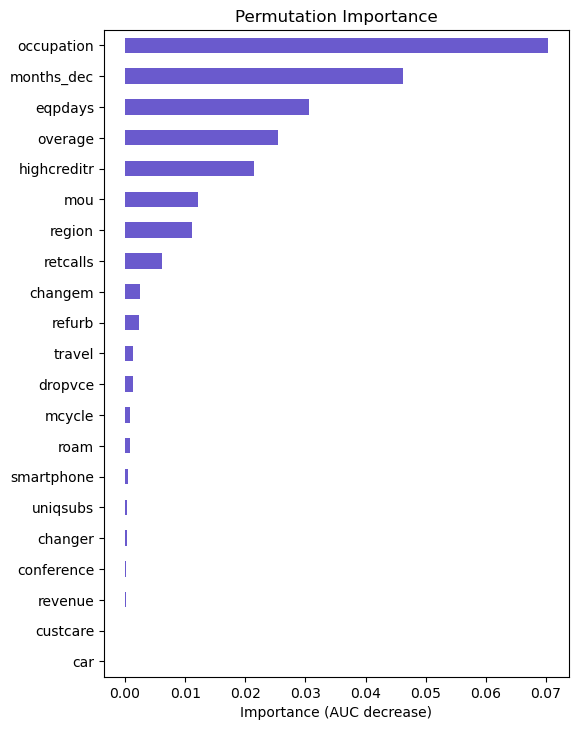

In [29]:
ret = rsm.vimp_plot_sm(lr_mdec, s_mobile.query("training == 1"), ret=True)

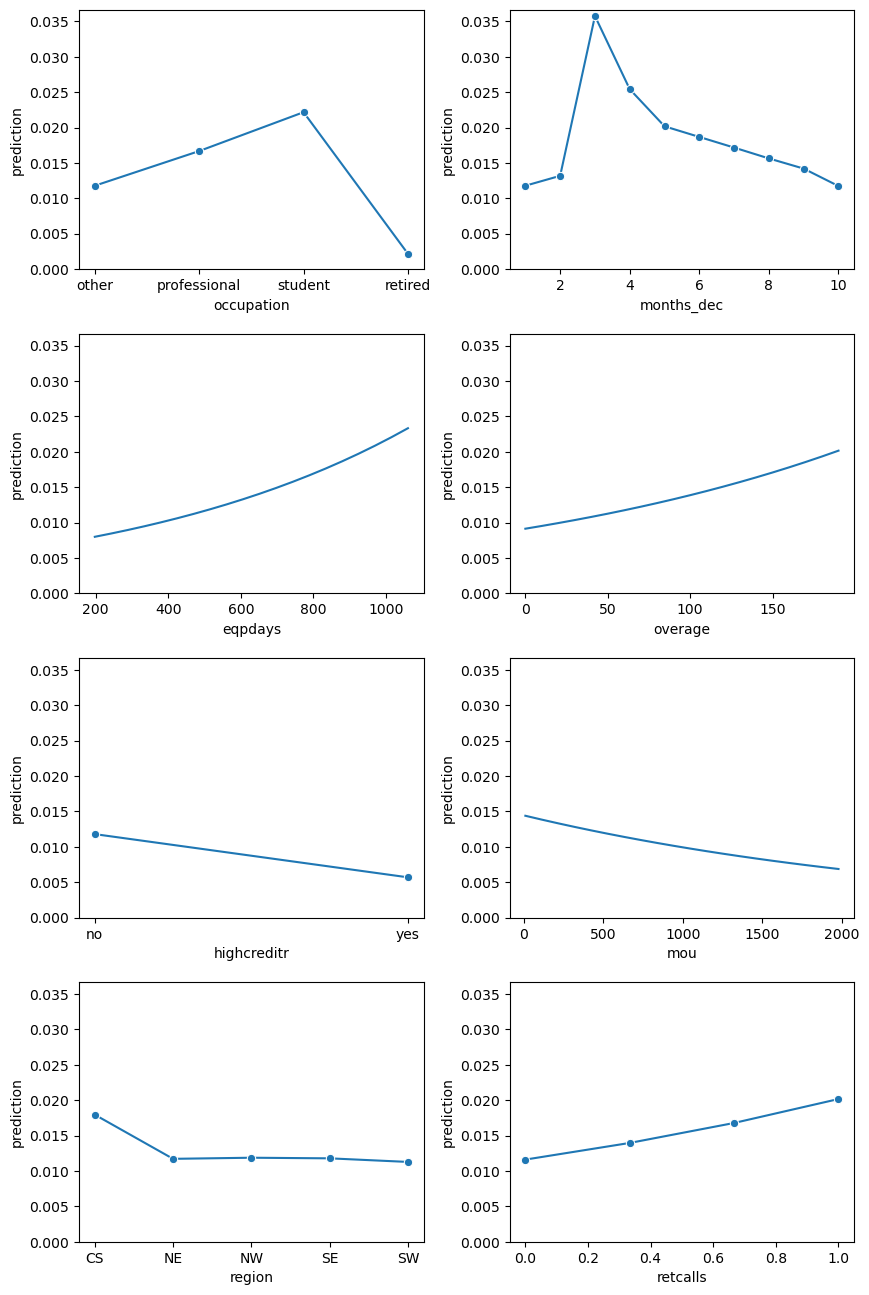

In [30]:
rsm.pred_plot_sm(lr_mdec, s_mobile.query("representative == 1"), incl=ret.index[:8])

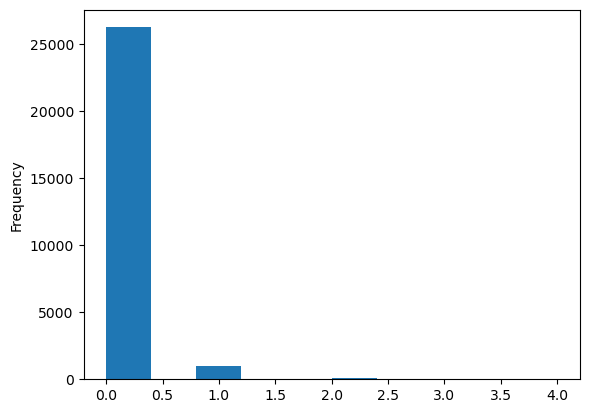

In [32]:
fig = s_mobile.loc[s_mobile.training == 1, "retcalls"].plot.hist()

Might `retcalls` (retention calls) have a non-linear effect?

In [33]:
s_mobile["retcalls_fct"] = rsm.ifelse(
    s_mobile.retcalls > 1, ">1", s_mobile.retcalls
)
s_mobile["retcalls_fct"] = s_mobile.retcalls_fct.astype("category")

In [34]:
pd.crosstab(s_mobile.retcalls_fct, columns="count")

col_0,count
retcalls_fct,
0.0,66764
1.0,2060
>1,176


In [35]:
evar = list(s_mobile.loc[:, "changer":"occupation"].columns) + [
    "months_dec",
    "retcalls_fct",
]
form = (
    "churn_yes ~ "
    + " + ".join(rsm.setdiff(evar, ["months", "retcalls"]))
    + " + I(overage**2) + I(overage**3)"
)
form

'churn_yes ~ car + changem + changer + conference + custcare + dropvce + eqpdays + highcreditr + mcycle + months_dec + mou + occupation + overage + refurb + region + retcalls_fct + revenue + roam + smartphone + travel + uniqsubs + I(overage**2) + I(overage**3)'

In [36]:
# s_mobile["retcalls_fct"] = rsm.ifelse(
#     s_mobile.retcalls > 1, ">1", s_mobile.retcalls
# )
# s_mobile["retcall_fct"] = s_mobile.retcalls.astype("category")

In [37]:
lr_fin = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=s_mobile.query("training == 1"),
).fit()
rsm.model_fit(lr_fin)
# rsm.or_ci(lr)


Pseudo R-squared (McFadden): 0.065
Pseudo R-squared (McFadden adjusted): 0.064
Area under the RO Curve (AUC): 0.716
Log-likelihood: -62588.379, AIC: 125252.757, BIC: 125687.231
Chi-squared: 729612.785 df(37), p.value < 0.001 
Nr obs: 682,500



In [38]:
rsm.model_fit(lr_fin)


Pseudo R-squared (McFadden): 0.065
Pseudo R-squared (McFadden adjusted): 0.064
Area under the RO Curve (AUC): 0.716
Log-likelihood: -62588.379, AIC: 125252.757, BIC: 125687.231
Chi-squared: 729612.785 df(37), p.value < 0.001 
Nr obs: 682,500



Turning `retcalls` into a categorical variables doesn't seem to have bumped up variable importance

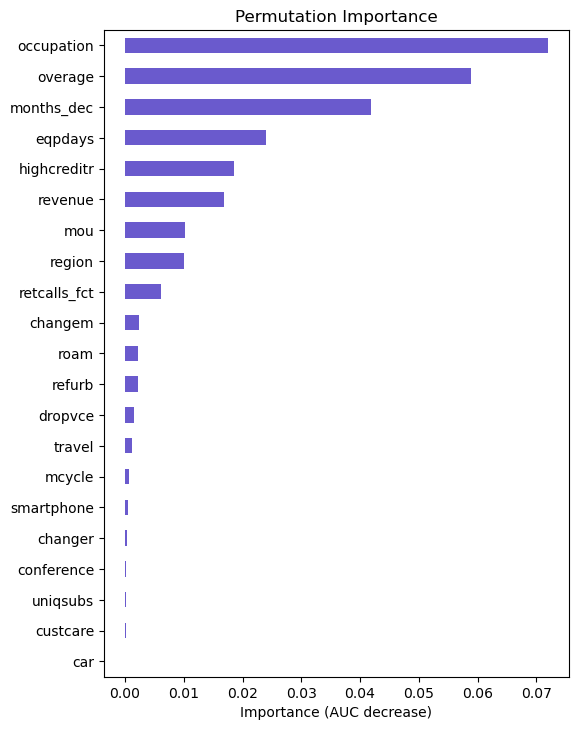

In [39]:
ret = rsm.vimp_plot_sm(lr_fin, s_mobile.query("training == 1"), ret=True)

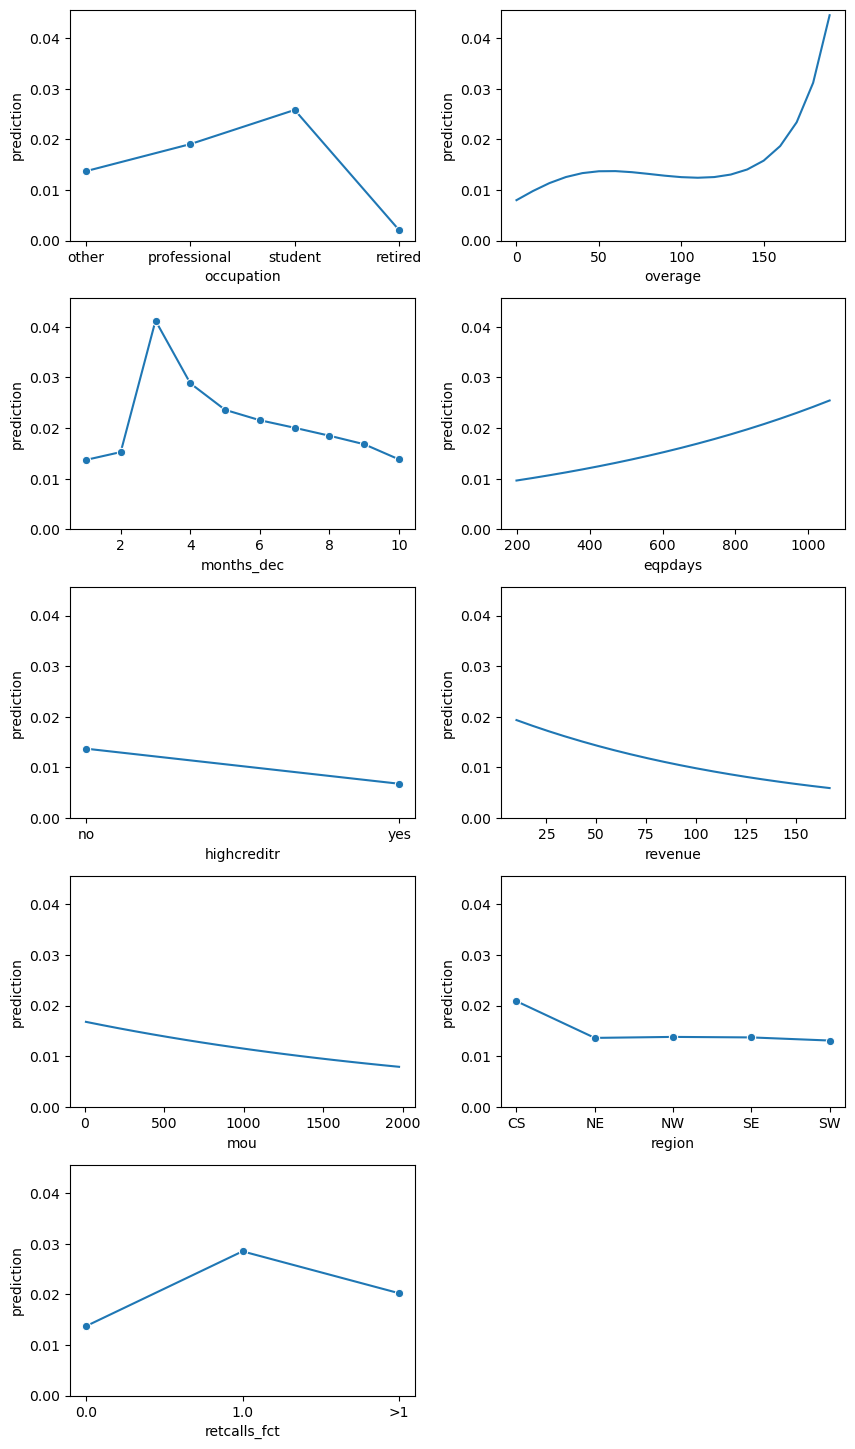

In [40]:
rsm.pred_plot_sm(lr_fin, s_mobile.query("representative == 1"), incl=ret.index[:9], hline=False)

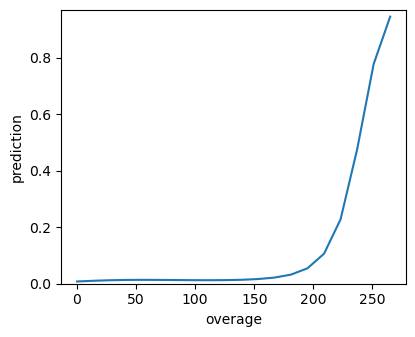

In [41]:
# not great
rsm.pred_plot_sm(lr_fin, s_mobile.query("representative == 1"), incl="overage", minq=0, maxq=1)

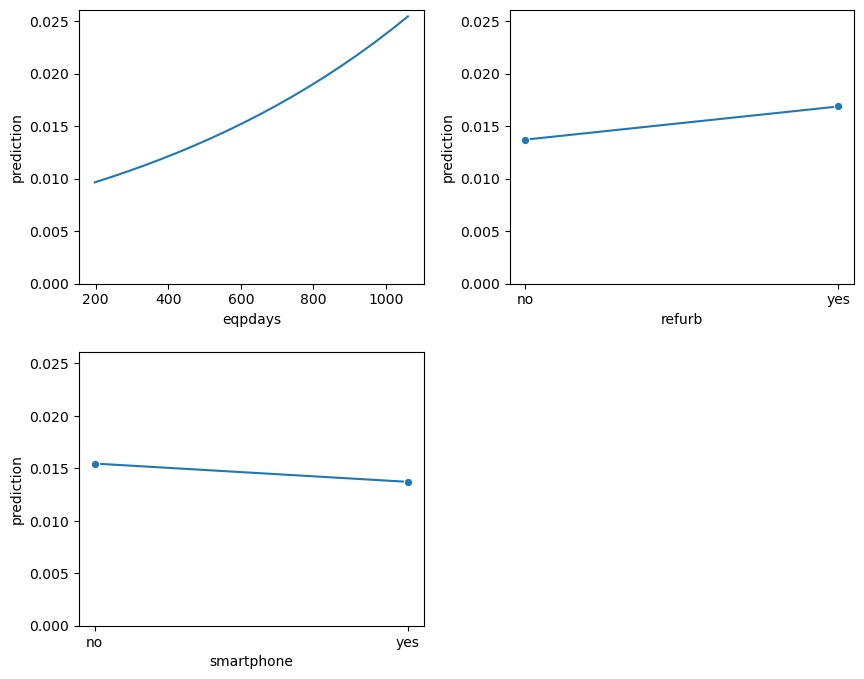

In [42]:
rsm.pred_plot_sm(
    lr_fin, s_mobile.query("representative == 1"), 
    incl=["eqpdays", "refurb", "smartphone"], hline=False
)

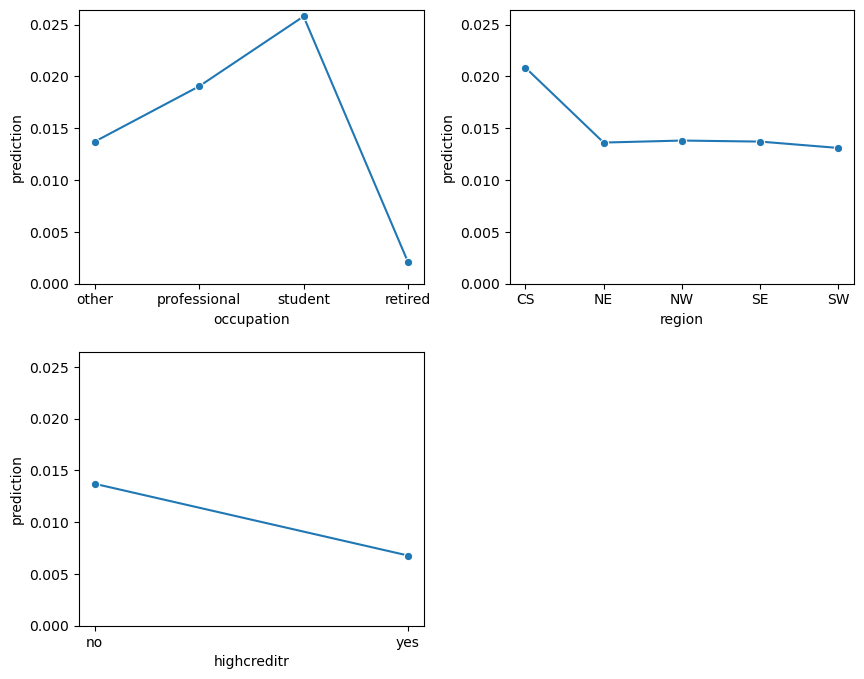

In [43]:
rsm.pred_plot_sm(
    lr_fin, s_mobile.query("representative == 1"), 
    incl=["occupation", "region", "highcreditr"], hline=False
)

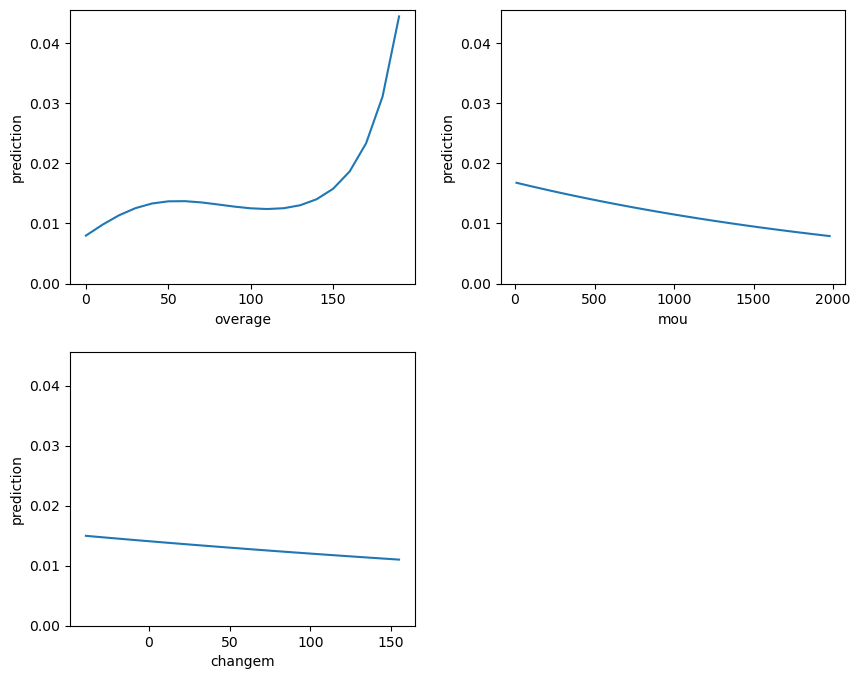

In [44]:
rsm.pred_plot_sm(
    lr_fin, s_mobile.query("representative == 1"), 
    incl=["overage", "mou", "changem"], hline=False
)

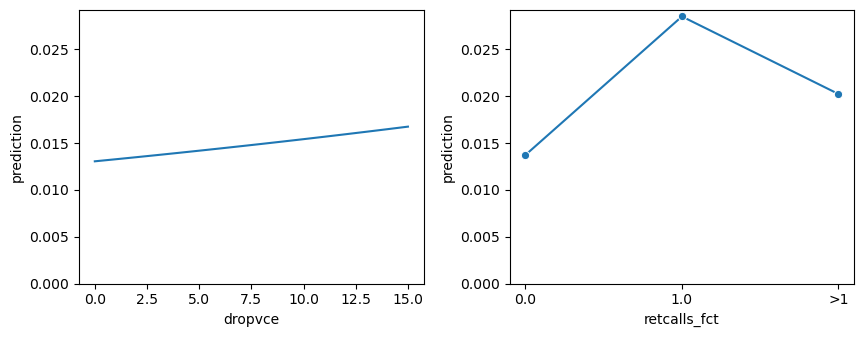

In [45]:
rsm.pred_plot_sm(
    lr_fin, s_mobile.query("representative == 1"), 
    incl=["dropvce", "retcalls_fct"], hline=False
)

Neural network was estimated and optimized in a s-mobile-nn-sol.ipynb

In [47]:
dct = rsm.load_state(path="s-mobile-nn-clf-cv.pkl")
# mod_eval = pd.concat([mod_eval, dct["mod_eval_nn"]], axis=1)
# mod_eval
dct

{'clf_cv': GridSearchCV(cv=5,
              estimator=MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                                      max_iter=10000, random_state=1234,
                                      solver='lbfgs'),
              n_jobs=4,
              param_grid={'alpha': [0.0001, 0.001, 0.1, 0.2, 0.3],
                          'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                 (6,), (3, 3), (4, 4), (5, 5)]},
              refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)}

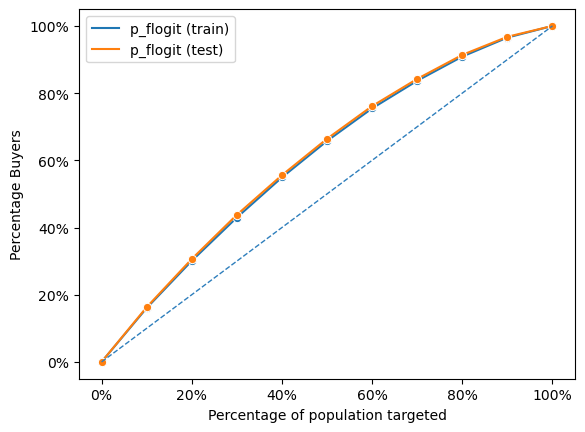

In [51]:
dct = {
    "train": mod_eval[mod_eval.training == 1],
    "test": mod_eval[mod_eval.training == 0],
}
fig = rsm.gains_plot(dct, "churn", "yes", "p_flogit")

In [53]:
s_mobile["eqpdays_dec"] = pd.Series(rsm.xtile(s_mobile.eqpdays, 10), dtype="category")
(
    s_mobile.query("representative == 1")
    .groupby("eqpdays_dec")[["eqpdays"]]
    .agg("min", "count")
    .astype(int)
)

,eqpdays
eqpdays_dec,
1,13
2,262
3,348
4,389
5,438
6,481
7,531
8,601
9,704


In [54]:
s_mobile["p_flogit"] = lr_fin.predict(s_mobile)
s_mobile.fillna({"training": -1}).groupby("training")[
    ["churn_yes", "p_flogit"]
].mean().round(3)

,churn_yes,p_flogit
training,,
-1.0,0.02,0.020
0.0,0.50,0.028
1.0,0.50,0.028


In [55]:
s_mobile["p_eqp438"] = lr_fin.predict(
    s_mobile.assign(eqpdays=rsm.ifelse(s_mobile.eqpdays > 438, 0, s_mobile.eqpdays))
)
s_mobile.loc[
    (s_mobile.representative == 1) & (s_mobile.eqpdays > 438),
    ["eqpdays", "p_flogit", "p_eqp438"],
].head(10).round(3)

,eqpdays,p_flogit,p_eqp438
10,516.0,0.010,0.005
11,675.0,0.036,0.017
14,682.0,0.049,0.023
20,1014.0,0.017,0.006
23,571.0,0.003,0.001
36,507.0,0.078,0.045
47,781.0,0.031,0.013
49,551.0,0.032,0.017
51,533.0,0.022,0.012
57,575.0,0.022,0.012


In [56]:
s_mobile["p_eqp438"] = lr_fin.predict(
    s_mobile.assign(
        eqpdays=rsm.ifelse(
            (s_mobile.eqpdays > 438) & (s_mobile.p_flogit > 0.02), 0, s_mobile.eqpdays
        )
    )
)
s_mobile.loc[
    (s_mobile.representative == 1) & (s_mobile.eqpdays > 438),
    ["eqpdays", "p_flogit", "p_eqp438"],
].head(10).round(3)

,eqpdays,p_flogit,p_eqp438
10,516.0,0.010,0.010
11,675.0,0.036,0.017
14,682.0,0.049,0.023
20,1014.0,0.017,0.017
23,571.0,0.003,0.003
36,507.0,0.078,0.045
47,781.0,0.031,0.013
49,551.0,0.032,0.017
51,533.0,0.022,0.012
57,575.0,0.022,0.012


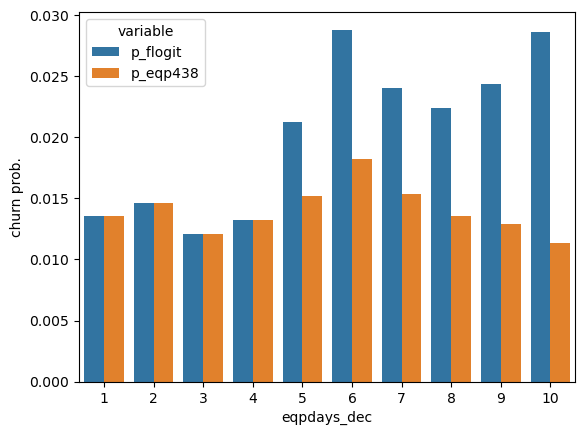

In [57]:
tmp = pd.melt(
    s_mobile[s_mobile.representative == 1],
    id_vars="eqpdays_dec",
    value_vars=["p_flogit", "p_eqp438"],
    value_name="churn prob.",
)
fig = sns.barplot(
    x="eqpdays_dec",
    y="churn prob.",
    hue="variable",
    data=tmp,
    errorbar=("ci", False)
)

In [58]:
pd.DataFrame(
    {
        "Churn prob.": s_mobile.loc[
            (s_mobile.representative == 1)
            & (s_mobile.eqpdays > 438)
            & (s_mobile.p_flogit > 0.02),
            ["p_flogit", "p_eqp438"],
        ].agg("mean")
    }
).round(3)

,Churn prob.
p_flogit,0.037
p_eqp438,0.018


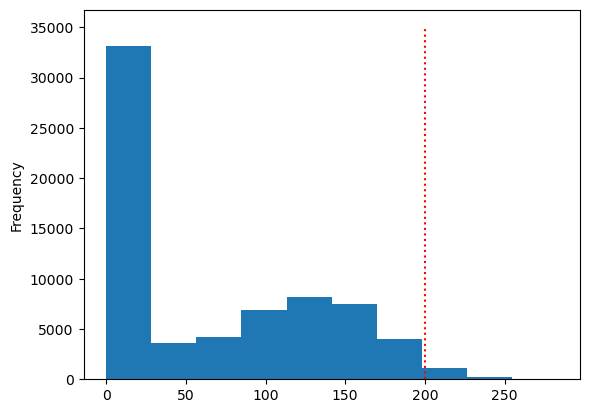

In [59]:
fig = s_mobile.overage.plot.hist()
fig = plt.vlines(x=200, ymin=0, ymax=35000, colors="red", ls=":")

In [60]:
s_mobile["overage200"] = rsm.ifelse(s_mobile.overage > 200, "> 200", "<= 200")
pd.DataFrame(
    {
        "Churn prob.": s_mobile.loc[
            (s_mobile.representative == 1) & (s_mobile.p_flogit > 0.02)
        ]
        .groupby("overage200")
        .churn_yes.agg("mean")
    }
).round(3)

,Churn prob.
overage200,
<= 200,0.035
> 200,0.064


In [61]:
df = rsm.sim_prediction(
    s_mobile[(s_mobile.representative == 1) & (s_mobile.p_flogit > 0.02)],
    vary={"dropvce": [0, 10]},
)
lr_fin.predict(df)

0    0.067926
1    0.079433
dtype: float64

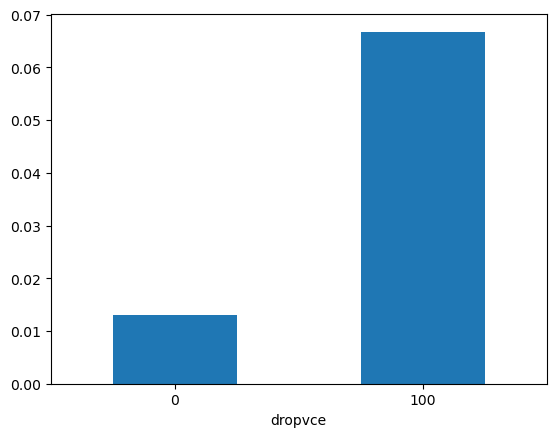

In [62]:
df = rsm.sim_prediction(
    s_mobile[(s_mobile.representative == 1)], vary={"dropvce": [0, 100]}
)
df["Prediction"] = lr_fin.predict(df)
fig = df.plot.bar(x="dropvce", y="Prediction", rot=False, legend=False)

In [63]:
s_mobile.groupby("dropvce")["churn_yes"].agg("mean")[[0, 10]]

dropvce
0     0.305170
10    0.298523
Name: churn_yes, dtype: float64

In [64]:
s_mobile.loc[
    (s_mobile.representative == 1) & (s_mobile.eqpdays > 438),
    ["eqpdays", "p_flogit", "p_eqp438"],
].head(10).round(3)

,eqpdays,p_flogit,p_eqp438
10,516.0,0.010,0.010
11,675.0,0.036,0.017
14,682.0,0.049,0.023
20,1014.0,0.017,0.017
23,571.0,0.003,0.003
36,507.0,0.078,0.045
47,781.0,0.031,0.013
49,551.0,0.032,0.017
51,533.0,0.022,0.012
57,575.0,0.022,0.012


In [65]:
pd.crosstab(
    s_mobile.loc[s_mobile.representative == 1, "region"],
    values=s_mobile.loc[s_mobile.representative == 1, "dropvce"],
    columns="Mean dropvce",
    aggfunc="mean",
).round(3)

col_0,Mean dropvce
region,
CS,3.040
NE,2.974
NW,3.010
SE,3.109
SW,3.016


In [66]:
pd.crosstab(
    s_mobile.loc[s_mobile.representative == 1, "region"],
    values=s_mobile.loc[s_mobile.representative == 1, "churn_yes"],
    columns="Mean churn",
    aggfunc="mean",
).round(3)

col_0,Mean churn
region,
CS,0.028
NE,0.018
NW,0.016
SE,0.019
SW,0.019


In [67]:
pd.crosstab(s_mobile.loc[s_mobile.representative == 1, "region"], columns="Count")

col_0,Count
region,
CS,5977
NE,5885
NW,6046
SE,6064
SW,6028


In [68]:
df = rsm.sim_prediction(
    s_mobile[(s_mobile.representative == 1)], vary={"dropvce": range(11)}
)
df["Prediction"] = lr_fin.predict(df)
pd.concat([df.loc[:, "changer":"region"].round(0), df.Prediction], axis=1)

,changer,changem,revenue,mou,overage,roam,conference,months,uniqsubs,custcare,...,dropvce,eqpdays,refurb,smartphone,highcreditr,mcycle,car,travel,region,Prediction
0,8,17,56,540,61,1,0,18,1,2,...,0,509.0,no,yes,no,no,no,no,SE,0.013038
1,8,17,56,540,61,1,0,18,1,2,...,1,509.0,no,yes,no,no,no,no,SE,0.013257
2,8,17,56,540,61,1,0,18,1,2,...,2,509.0,no,yes,no,no,no,no,SE,0.013480
3,8,17,56,540,61,1,0,18,1,2,...,3,509.0,no,yes,no,no,no,no,SE,0.013706
4,8,17,56,540,61,1,0,18,1,2,...,4,509.0,no,yes,no,no,no,no,SE,0.013937
5,8,17,56,540,61,1,0,18,1,2,...,5,509.0,no,yes,no,no,no,no,SE,0.014171
6,8,17,56,540,61,1,0,18,1,2,...,6,509.0,no,yes,no,no,no,no,SE,0.014408
7,8,17,56,540,61,1,0,18,1,2,...,7,509.0,no,yes,no,no,no,no,SE,0.014650
8,8,17,56,540,61,1,0,18,1,2,...,8,509.0,no,yes,no,no,no,no,SE,0.014896
9,8,17,56,540,61,1,0,18,1,2,...,9,509.0,no,yes,no,no,no,no,SE,0.015146


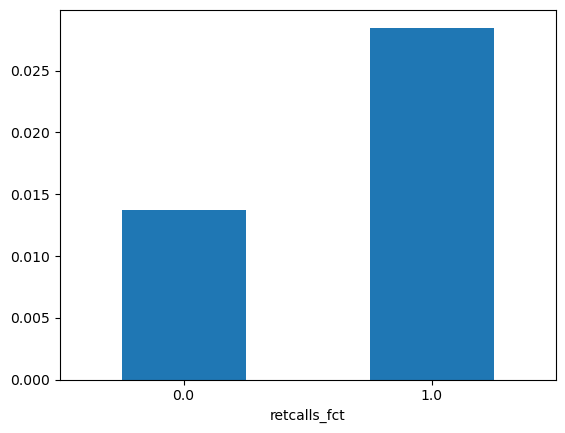

In [69]:
df = rsm.sim_prediction(
    s_mobile[(s_mobile.representative == 1)], vary={"retcalls_fct": ["0.0", "1.0"]}
)
df["Prediction"] = lr_fin.predict(df)
fig = df.plot.bar(x="retcalls_fct", y="Prediction", rot=False, legend=False)

Average revenue for CLV calculation 

In [70]:
s_mobile.query("p_flogit > 0.02 & representative == 1 & eqpdays > 438").revenue.mean()

48.81271853146853

In [71]:
s_mobile.query("p_flogit > 0.02 & representative == 1 & eqpdays > 438").churn_yes.mean()

0.03704108391608392

In [72]:
s_mobile.query("p_flogit > 0.02 & representative == 1 & eqpdays > 438").p_eqp438.mean()

0.017751859985321257